# Loading the Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
PROJECT_PATH = '/content/drive/My Drive/Datasets/ML Project'
DATASETS_PATH = f'{PROJECT_PATH}/data/recommended'
TRAINING_PATH = f'{DATASETS_PATH}/training/training_cleaned.csv'
FIGURES_PATH = f'{PROJECT_PATH}/figures/eda'
INDEX_COL = 'pkSeqID'

In [4]:
import pandas as pd

training = pd.read_csv(TRAINING_PATH, index_col=INDEX_COL)
training.head()

,min,max,mean,stddev,N_IN_Conn_P_SrcIP,N_IN_Conn_P_DstIP,drate,srate,sport,dport,proto,state_number,category
pkSeqID,,,,,,,,,,,,,
3142762,0.000000,4.031619,2.687519,1.900363,100,100,0.0,0.494549,6551,80,udp,4,DDoS UDP
2432264,3.856930,4.012924,3.934927,0.078003,38,100,0.0,0.256493,5532,80,tcp,3,DDoS TCP
1976315,2.974100,3.609205,3.341429,0.268666,100,100,0.0,0.294880,27165,80,tcp,3,DDoS TCP
1240757,0.000000,4.942302,3.222832,1.823185,63,63,0.0,0.461435,48719,80,udp,4,DoS UDP
3257991,2.979995,4.994452,3.983222,0.822418,100,100,0.0,1.002999,22461,80,udp,4,DDoS UDP


In [4]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2934817 entries, 3142762 to 96906
Data columns (total 13 columns):
 #   Column             Dtype  
---  ------             -----  
 0   min                float64
 1   max                float64
 2   mean               float64
 3   stddev             float64
 4   N_IN_Conn_P_SrcIP  int64  
 5   N_IN_Conn_P_DstIP  int64  
 6   drate              float64
 7   srate              float64
 8   sport              int64  
 9   dport              int64  
 10  proto              object 
 11  state_number       int64  
 12  category           object 
dtypes: float64(6), int64(5), object(2)
memory usage: 313.5+ MB


## Imports

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox

# Number of inbound connections per IP address

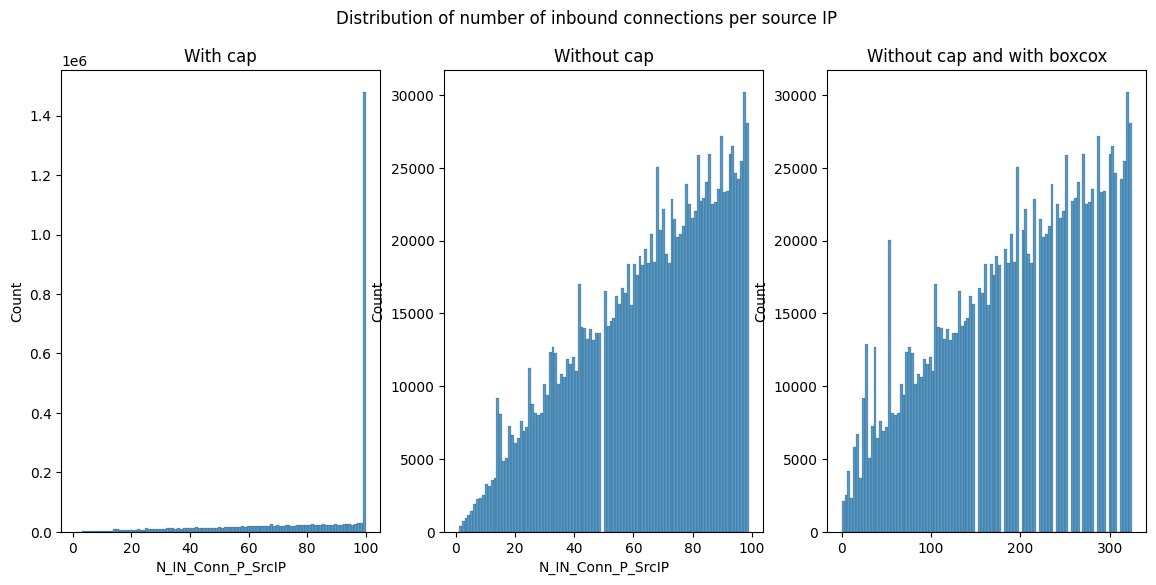

In [29]:
fig, axes = plt.subplots(1, 3)

sns.histplot(
    x=training['N_IN_Conn_P_SrcIP'],
    bins=100,
    ax=axes[0],
)

sns.histplot(
    x=training.loc[training['N_IN_Conn_P_SrcIP'] < 100, 'N_IN_Conn_P_SrcIP'],
    bins=100,
    ax=axes[1]
)

x, _ = boxcox(training.loc[training['N_IN_Conn_P_SrcIP'] < 100, 'N_IN_Conn_P_SrcIP'])
sns.histplot(
    x=x,
    bins=100,
    ax=axes[2]
)

axes[0].set_title('With cap')
axes[1].set_title('Without cap')
axes[2].set_title('Without cap and with boxcox')

fig.suptitle('Distribution of number of inbound connections per source IP')

fig.set_size_inches(14, 6)
plt.savefig(f'{FIGURES_PATH}/n_inbound_conn_per_src_ip.png')


Clearly a cap is set at the value of 100, and since most of the traffic is for ddos/dos attacks, it is most common value

Outside of that the distribution of traffic is linear

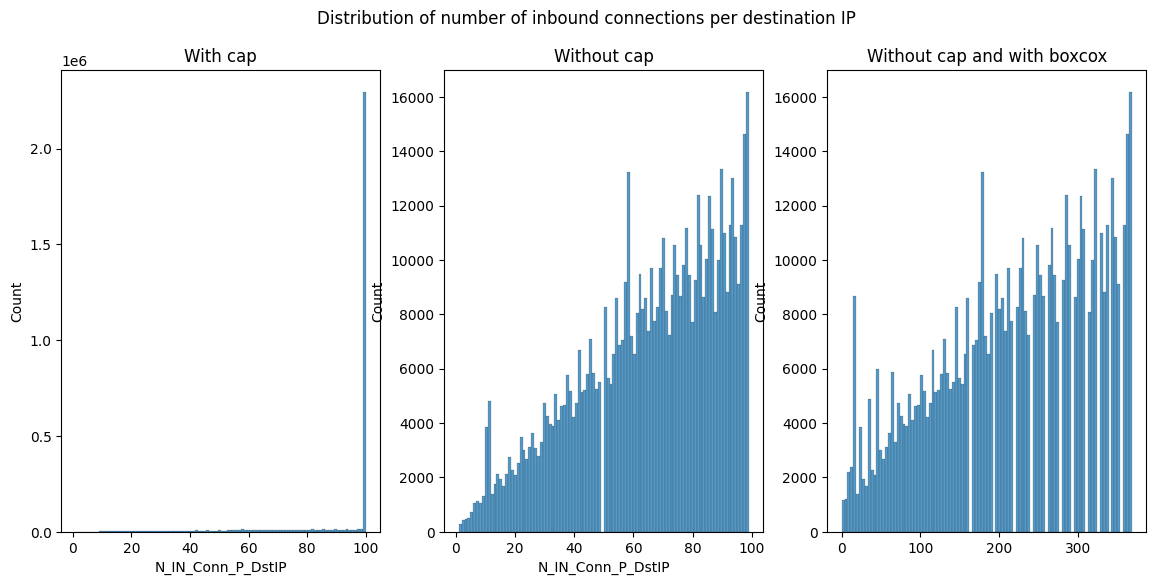

In [30]:
fig, axes = plt.subplots(1, 3)

training.N_IN_Conn_P_DstIP
sns.histplot(
    x=training['N_IN_Conn_P_DstIP'],
    bins=100,
    ax=axes[0],
)

sns.histplot(
    x=training.loc[training['N_IN_Conn_P_DstIP'] < 100, 'N_IN_Conn_P_DstIP'],
    bins=100,
    ax=axes[1]
)

x, _ = boxcox(training.loc[training['N_IN_Conn_P_DstIP'] < 100, 'N_IN_Conn_P_DstIP'])
sns.histplot(
    x=x,
    bins=100,
    ax=axes[2]
)

axes[0].set_title('With cap')
axes[1].set_title('Without cap')
axes[2].set_title('Without cap and with boxcox')

fig.suptitle('Distribution of number of inbound connections per destination IP')

fig.set_size_inches(14, 6)
plt.savefig(f'{FIGURES_PATH}/n_inbound_conn_per_src_ip.png')


/tmp/ipython-input-3526175921.py:3: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{FIGURES_PATH}/Scatter plot of inbound connection per src ip with respect to dst ip.png')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


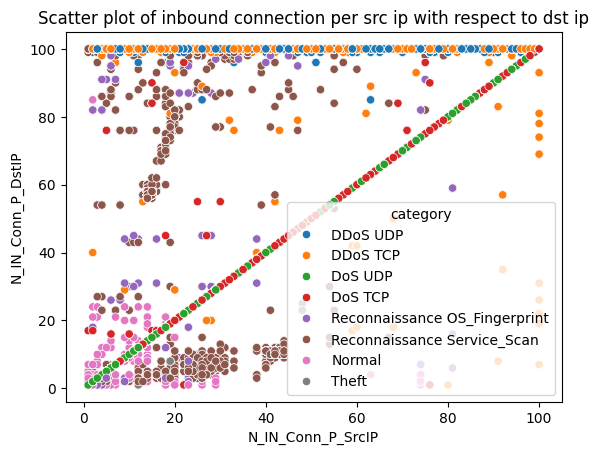

In [37]:
sns.scatterplot(x='N_IN_Conn_P_SrcIP', y='N_IN_Conn_P_DstIP', hue='category', data=training)
plt.title('Scatter plot of inbound connection per src ip with respect to dst ip')
plt.savefig(f'{FIGURES_PATH}/Scatter plot of inbound connection per src ip with respect to dst ip.png')

We can recognize some patterns as per attack type:
- **DDoS Attacks:** Tend to have a high number of inbound traffic destined to the same IP address, without much relation to the source IP (suggesting some machines sent huge traffic compared to others), which is expected since the attack is distributed, the type of protocol (`udp` or `tcp`) is not relevant
- **DoS Attacks:** The number of inbound traffic per destination and source IP are correlated, since the attack is sent from a single machine to a specific target, again the protocol is irrelevant
- **Reconnaissonce OS fingerprint:** seem to have a weird pattern were either really high traffic per dst ip (meaning same target) with low traffic per src ip (meaning the rate of messages is very low); or somewhat low src traffic and low dst traffic
- **Normal Traffic:** as expected normal traffic has a low rate for both src IP and dst IP

65


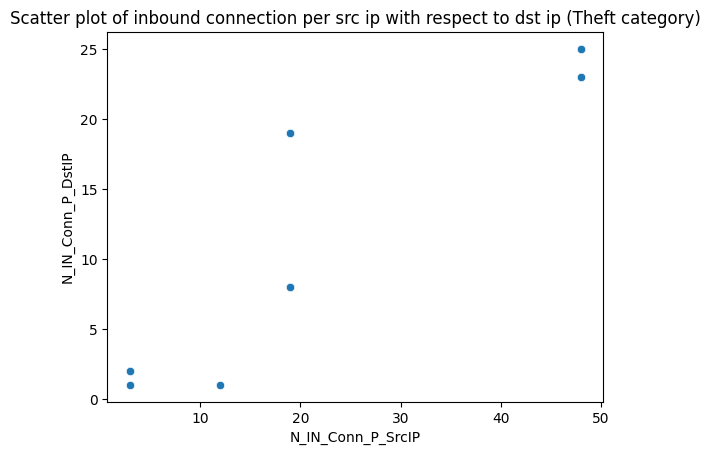

In [41]:
d = data=training.loc[training['category'] == 'Theft']
print(len(d))
sns.scatterplot(x='N_IN_Conn_P_SrcIP', y='N_IN_Conn_P_DstIP', data=d)
plt.title('Scatter plot of inbound connection per src ip with respect to dst ip (Theft category)')
plt.savefig(f'{FIGURES_PATH}/Scatter plot of inbound connection per src ip with respect to dst ip (Theft category).png')

**Theft** generally seems to follow a linear line, but no conclusions can be made

# Packet Rates

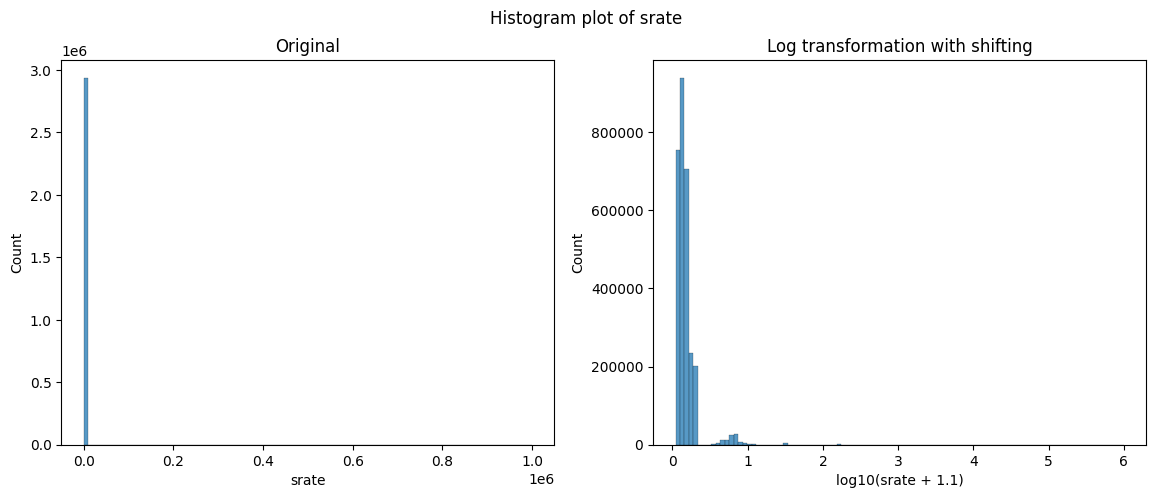

In [25]:
fig, axes = plt.subplots(1, 2)
sns.histplot(x=training.loc[:, 'srate'], bins=100, ax=axes[0])
axes[0].set_title('Original')

sns.histplot(x=np.log10(training['srate'] + 1.1), bins=100, ax=axes[1])
axes[1].set_title('Log transformation with shifting')
axes[1].set_xlabel('log10(srate + 1.1)')

fig.suptitle('Histogram plot of srate')
fig.set_size_inches(14, 5)
plt.savefig(f'{FIGURES_PATH}/distribution of srate.png')

As we can notice applying the log transformation makes the distribution a lot more normal, when it comes to `srate`(specific handling using by eliminating 0 is also done)

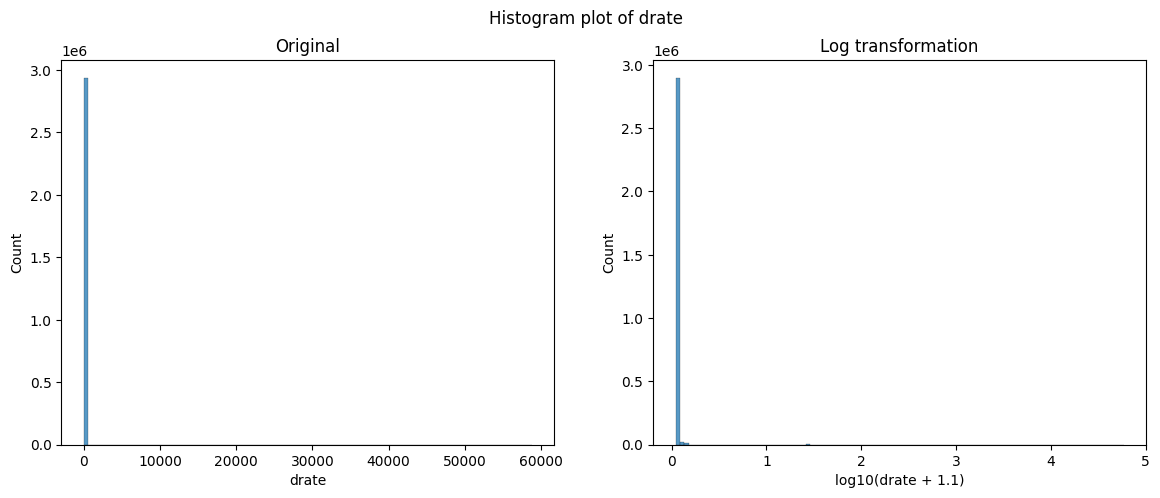

In [26]:
fig, axes = plt.subplots(1, 2)
sns.histplot(x=training.loc[:, 'drate'], bins=100, ax=axes[0])
axes[0].set_title('Original')

sns.histplot(x=np.log10(training.loc[:, 'drate'] + 1.1), bins=100, ax=axes[1])
axes[1].set_title('Log transformation')
axes[1].set_xlabel('log10(drate + 1.1)')

fig.suptitle('Histogram plot of drate')
fig.set_size_inches(14, 5)
plt.savefig(f'{FIGURES_PATH}/distribution of drate.png')

The logarithmic function with 1 added didn't perform so well in fixing the distributions, another solution is to assign the zero values a really low value, this is due to the fact that a high number of rates is close or equal to 0

In [6]:
training_chk1 = training.copy()
training['srate'] = np.log10(training['srate'] + 1.1)
training['drate'] = np.log10(training['drate'] + 1.1)

In [7]:
training['srate_to_drate'] = training['srate'] / training['drate']

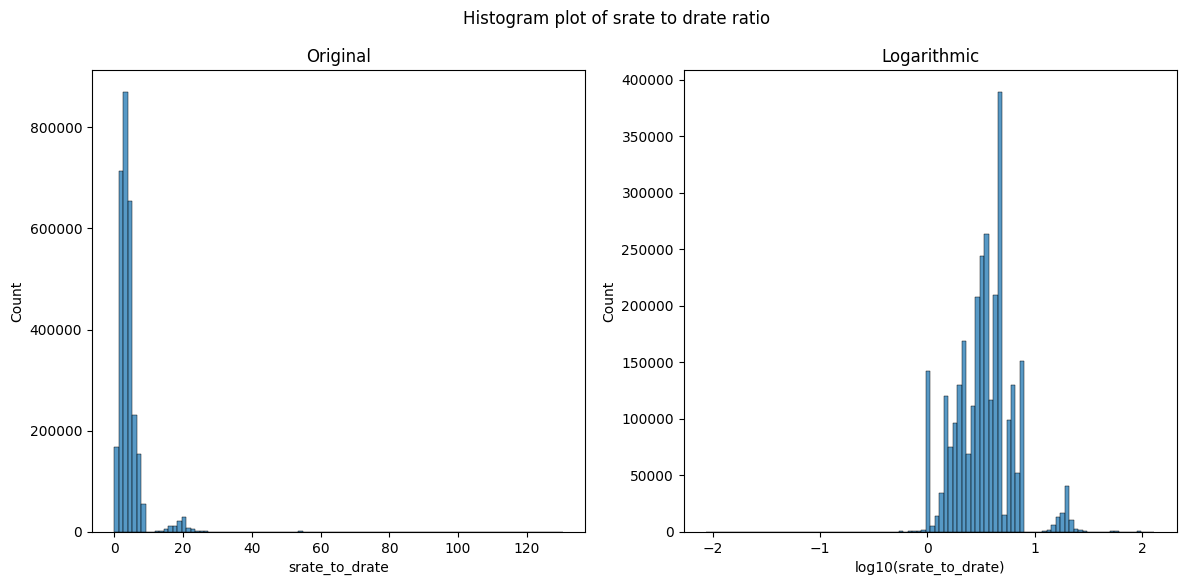

In [8]:
fig, axes = plt.subplots(1, 2)
title = 'Histogram plot of srate to drate ratio'
fig.suptitle(title)
fig.set_size_inches(14, 6)

sns.histplot(x=training['srate_to_drate'], bins=100, ax=axes[0])
axes[0].set_title('Original')

sns.histplot(x=np.log10(training['srate_to_drate']), bins=100, ax=axes[1])
axes[1].set_title('Logarithmic')
axes[1].set_xlabel('log10(srate_to_drate)')

plt.savefig(f'{FIGURES_PATH}/{title}.png')

Applying the logarithm makes the distribution more normal

In [9]:
training_chk2 = training.copy()
training['srate_to_drate'] = np.log10(training['srate_to_drate'])

/tmp/ipython-input-397057068.py:3: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f'{FIGURES_PATH}/Scatter plot of log10(srate + 1.1) to log10(drate + 1.1).png')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


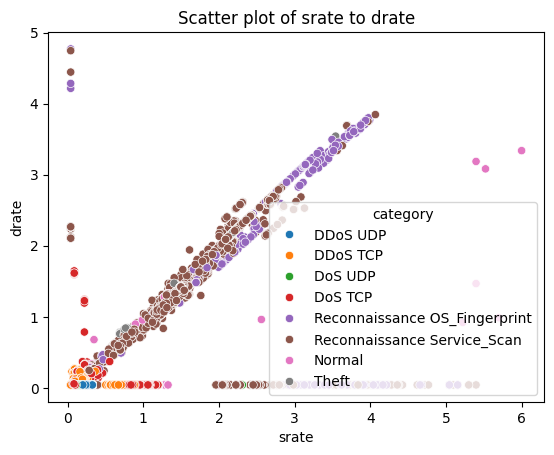

In [39]:
sns.scatterplot(data=training, hue='category', x='srate', y='drate')
plt.title('Scatter plot of srate to drate')
plt.savefig(f'{FIGURES_PATH}/Scatter plot of log10(srate + 1.1) to log10(drate + 1.1).png')

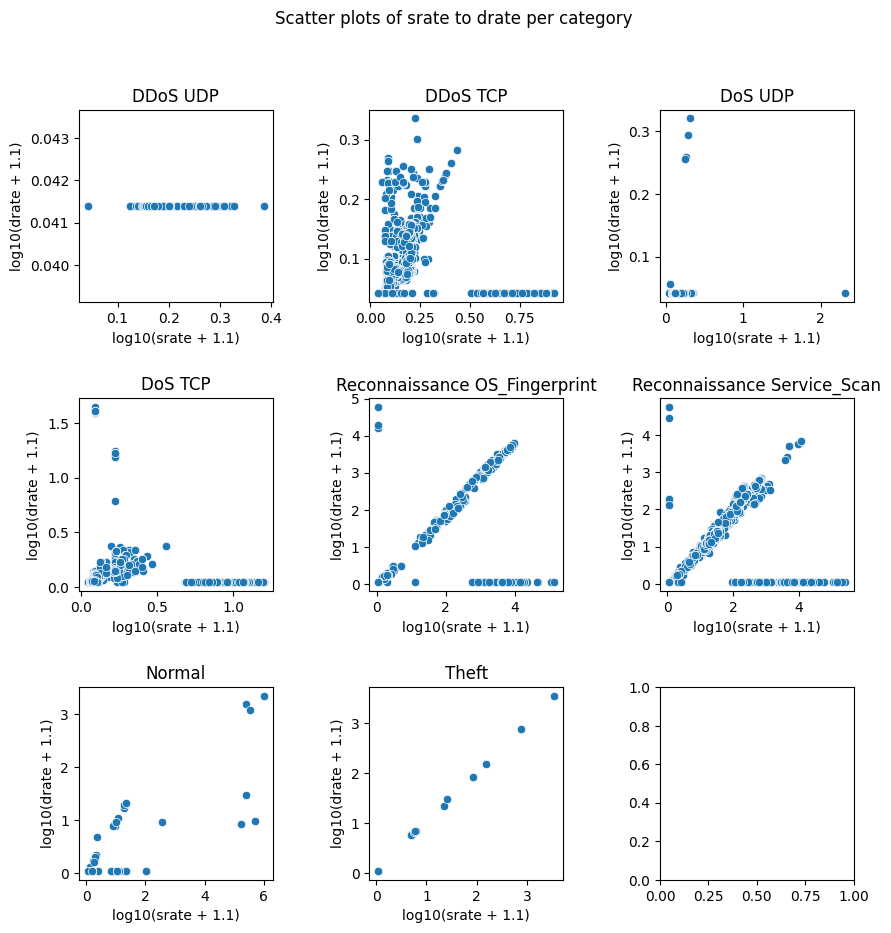

In [40]:
categories = training['category'].unique()
fig, axes = plt.subplots(3, 3)

for i in range(3):
  for j in range(3):
    if 3*i + j > 7:
      continue
    category = categories[3* i + j]
    axes[i, j].set_title(category)
    axes[i, j].set_xlabel('log10(srate + 1.1)')
    axes[i, j].set_ylabel('log10(drate + 1.1)')
    sns.scatterplot(
        data=training.loc[training['category'] == category],
        x='srate',
        y='drate',
        ax=axes[i, j]
    ).figure.subplots_adjust(wspace=0.5, hspace=0.5)

fig.set_size_inches(10, 10)
fig.suptitle('Scatter plots of srate to drate per category')
plt.savefig(f'{FIGURES_PATH}/Scatter plots of srate to drate per category.png')

- **Linear Relationships:** `Reconnaissance` and `Theft` attacks seem to exihibit a linear relationship between `srate` and `drate`

In [11]:
from sklearn.model_selection import train_test_split
training_sample, _ = train_test_split(training, random_state=42, train_size=0.4, stratify=training['category'])

In [ ]:
sns.swarmplot(data=training_sample, x='category', y='srate_to_drate')
title = 'Swarm plot of srate with respect to drate'
plt.title(title)
plt.savefig(f'{FIGURE_PATH}/{title}.png')

# Duration of Aggregated Records

In [ ]:
sns.boxplot

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

X = training.drop('category', axis=1)
y = training['category']
labeler = LabelEncoder()
y_train = labeler.fit_transform(y)

transformer = ColumnTransformer([
    ('encode', OneHotEncoder(), ['proto']),
    ('other', 'passthrough', list(set(X.columns) - set(['proto']))),

])
X_train = transformer.fit_transform(X)

In [76]:
from sklearn.model_selection import cross_val_score

model = LogisticRegression()
scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
print(f'Mean score: {scores.mean()} (+/- {2 * scores.std()})')

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py", line 1222, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py", line 1107, in check_array
    _assert_all_finite(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py", line 120, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py", line 169, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains infinity or a value too large for dtype('float64').
